# Lecture/Tutorial 1 - Tim Vogels
### Integrate and fire & Hodgkin Huxeley Neuron

I&F neuron can be analytically approximated for small time steps, without relying on a numerical integrator, by assuming that E_effective (conductance changes) occur are constant within the simulation timestep.

In [205]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
# import brian2

In [83]:
# define constants
Cm = 0.01
g_l = 1
E_l = -70
E_ex = 0
V_th = -54
V_reset = -80
dg_ex = 0.5
tau_ex = 0.01
V0 = -70

dt = 0.001
T = 1
t = np.linspace(0,T,1/dt+1)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


# Exercise 1: vanilla IF neuron

In [84]:
def comp_g_tot(g_l, g_syn):
    return g_l+g_syn

def comp_tau_eff(C, g_l, g_syn):
    return C/comp_g_tot(g_l, g_syn)

def comp_g_decay(g_cur, tau_g, dt, g0=0):
    return g_cur*np.exp(-dt/tau_g)

def comp_E_eff(g_l, g_syn, E_l, E_syn):
    return (g_l*E_l + g_syn*E_syn)/comp_g_tot(g_l, g_syn)

def comp_V_next(dt, E_eff, V, tau_eff):
    return (E_eff + (V-E_eff)*np.exp(-(dt/tau_eff)))


Text(0.5,1,'E Current')

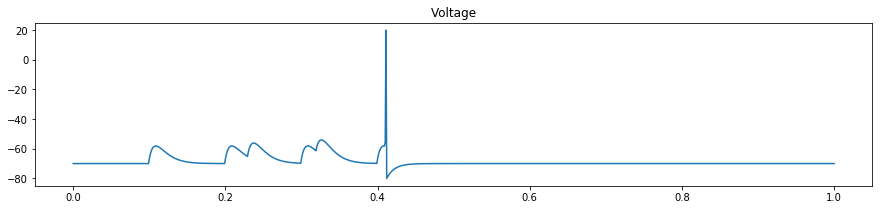

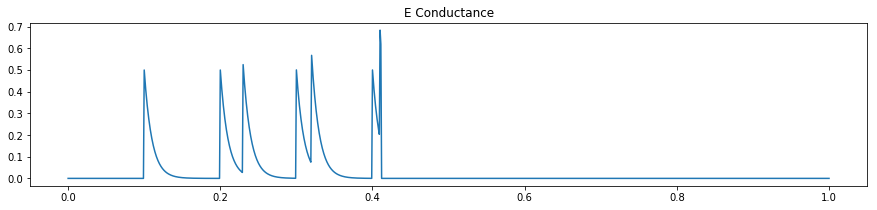

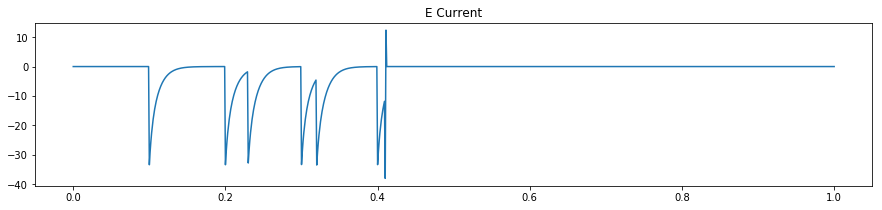

In [85]:
V = np.zeros_like(t)
g_ex = np.zeros_like(t)
spike_time = np.array([0.1, 0.2, 0.23, 0.3, 0.32, 0.4, 0.41])

V[0] = V0
for i, it in enumerate(t[1:]):
    # update synaptic conductance
    g_ex[i+1] = comp_g_decay(g_ex[i], tau_ex, dt)+(min(abs(spike_time-it))<1e-10)*dg_ex
    
    # update membrane voltage
    if V[i]>=V_th:
        # spikes
        V[i+1]=V_reset; V[i]=20; g_ex[i+1] = 0
    else:
        # don't spike
        V[i+1] = comp_V_next(dt, comp_E_eff(g_l, g_ex[i+1], E_l, E_ex), V[i], 
                             comp_tau_eff(Cm,g_l,g_ex[i+1]))

I_ex = g_ex*(V-E_ex)
plt.figure(figsize=(15,3))
plt.plot(t,V)
plt.title('Voltage')
plt.figure(figsize=(15,3))
plt.plot(t,g_ex)
plt.title('E Conductance')
plt.figure(figsize=(15,3))
plt.plot(t,I_ex)
plt.title('E Current')

# Exercise 2: IF neuron with noise input

Text(0,0.5,'Vm std')

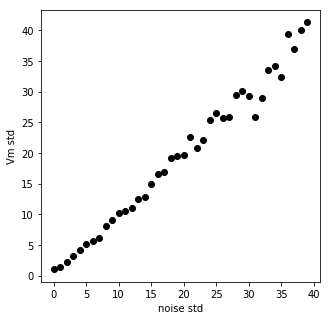

In [148]:
sig_max = 40
tau_m = 0.01
plt.figure(figsize=(5,5))
for sig_v in range(sig_max):
    E_eff_noise = -56+sig_v*(np.sqrt(2*tau_m/dt))*np.random.randn(len(t))
    V = np.zeros_like(t)
    V[0] = V0
    for i, it in enumerate(t[1:]):
        # update membrane voltage
        if V[i]>=1000:#V_th:
            # spikes
            V[i+1]=V_reset; V[i]=20; g_ex[i+1] = 0
        else:
            # don't spike
            V[i+1] = comp_V_next(dt, E_eff_noise[i], V[i], tau_m)

    plt.plot(sig_v, np.std(V), 'ko')

plt.xlabel('noise std')
plt.ylabel('Vm std')

Text(0.5,0,'noise std')

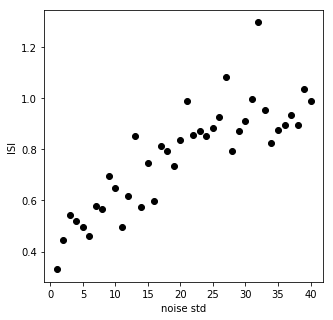

In [167]:
plt.figure(figsize=(5,5))
for sig_v in range(1,41):
    tau_m = 0.01
    E_eff_noise = -56+sig_v*(np.sqrt(2*tau_m/dt))*np.random.randn(len(t))
    V = np.zeros_like(t)
    V[0] = V0
    for i, it in enumerate(t[1:]):
        # update membrane voltage
        if V[i]>=V_th:
            # spikes
            V[i+1]=V_reset; V[i]=20; g_ex[i+1] = 0
        else:
            # don't spike
            V[i+1] = comp_V_next(dt, E_eff_noise[i], V[i], tau_m)
    
#    plt.plot(sig_v, sum(V>10)/T, 'ko')
#    plt.ylabel('firing rate')

    ISI = np.diff(np.where(V>10)[0]*dt)
    plt.plot(sig_v, np.std(ISI)/np.mean(ISI), 'ko')
    plt.ylabel('ISI')
#     print(np.std(ISI)/np.mean(ISI))

plt.xlabel('noise std')




40.513197097756816

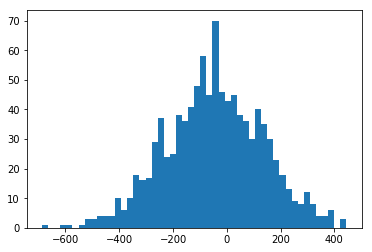

In [151]:
plt.hist(E_eff_noise,50);
np.std(E_eff_noise/np.sqrt(2*tau_m/dt))

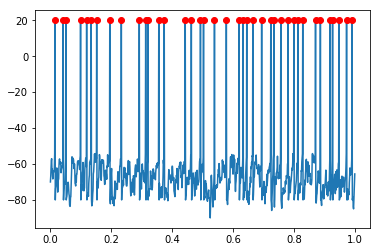

In [138]:
plt.plot(t,V)
plt.plot(t[V>10],V[V>10],'ro')

The membrane potential std is equal to the noise input std in this formulation. And firing rate scales with input std, about 4 times as much? ISI also increases as a function of input std??

# Exercise 3: HH Neuron

In [177]:
def compute_ab(V):
    a_n = 0.01*(V+55)/(1-np.exp(-0.1*(V+55)))
    b_n = 0.125*np.exp(-0.0125*(V+65))
    
    a_m = 0.1*(V+40)/(1-np.exp(-0.1*(V+40)))
    b_m = 4*np.exp(-0.0556*(V+65))
    
    a_h = 0.07*np.exp(-0.05*(V+65))
    b_h = 1/(1+np.exp(-0.1*(V+35)))
    
    return a_n,b_n,a_m,b_m,a_h,b_h
    
def compute_gatevar(a,b):
    tau = 1/(a+b)
    inf = a/(a+b)
    return tau, inf
    
def HH(t, y):
    V,n,m,h = y
    a_n,b_n,a_m,b_m,a_h,b_h = compute_ab(V)
    tau_n, n_inf = compute_gatevar(a_n,b_n)
    tau_m, m_inf = compute_gatevar(a_m,b_m)
    tau_h, h_inf = compute_gatevar(a_h,b_h)
    
    dndt = (n_inf-n)/tau_n
    dmdt = (m_inf-m)/tau_m
    dhdt = (h_inf-h)/tau_h
    
    i_m = g_l*(V-E_l)+g_k*n**4*(V-E_k)+g_na*m**3*h*(V-E_na)
    
    dVdt = (-i_m+I_c_A)/c_m
    return dVdt, dndt, dmdt, dhdt

In [253]:
from scipy import integrate, signal
c_m = 10
V0 = -65
m0 = 0.0529
h0 = 0.5961
n0 = 0.3177
g_l = 0.003*1000
g_k = 0.36*1000
g_na = 1.2*1000
E_l = -54.387
E_k = -77
E_na = 50

dt = 0.1
T = 500
t = np.arange(0,T,dt)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars
/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


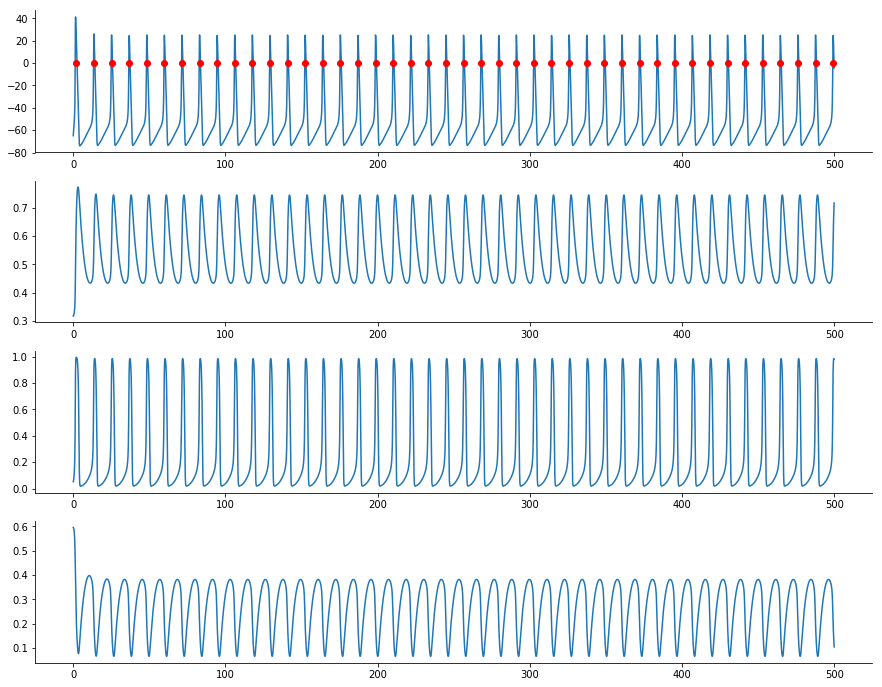

In [254]:
I_c_A = 200
solver = integrate.solve_ivp(HH, t_span=(0,T), y0=(V0, n0, m0, h0), t_eval=t)
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(solver.t, solver.y.T[:,i])
    sns.despine()

plt.subplot(4,1,1)
spike_inds = signal.find_peaks(solver.y[0])[0]
plt.plot(solver.t[spike_inds], solver.y.T[spike_inds,i], 'or')

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars
/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:140: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol
/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: invalid value encountered in true_divide
  error_norm = norm(error / scale)


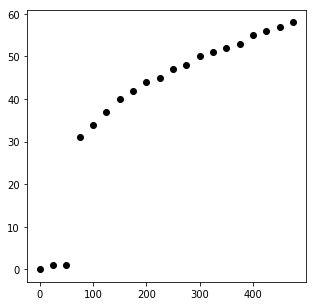

In [267]:
plt.figure(figsize=(5,5))
Vs = []
for I_in in np.arange(0,500,25):
    I_c_A = I_in
    solver = integrate.solve_ivp(HH, t_span=(0,T), y0=(V0, n0, m0, h0), t_eval=t)
    Vs.append(solver.y)
    spike_inds = signal.find_peaks(solver.y[0], height=0)[0]
    plt.plot(I_c_A, len(spike_inds), 'ko')

# Looking at HH neuron in phase space, including delay embedding
If the trajectory is embedded in the same number of dimensions as the relevant state variables, can you describe it in an N-dimensional radial and angular variable? What is angle/phase in more than 2D? But angle wrt origin is not unique?

**Increasing lag past some point makes the trajectory fold onto itself which means it's a projection, e.g. 40**

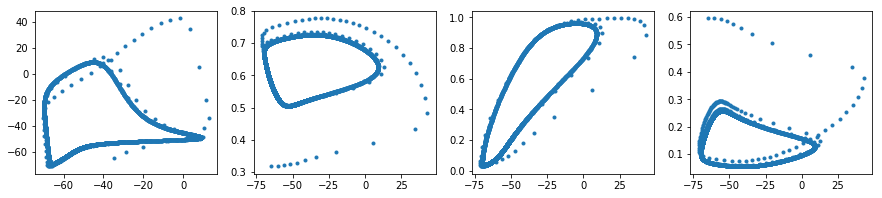

In [283]:
lag = 100
plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(Vs[-1][0,lag:], Vs[-1][0,:-lag], '.')

plt.subplot(1,4,2)
plt.plot(Vs[-1][0,:], Vs[-1][1,:], '.')

plt.subplot(1,4,3)
plt.plot(Vs[-1][0,:], Vs[-1][2,:], '.')

plt.subplot(1,4,4)
plt.plot(Vs[-1][0,:], Vs[-1][3,:], '.')